In [222]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [223]:
df = pd.read_csv('scaler_clustering.csv')

In [224]:
# Each and every unique email is of a student who has studied or is studying at scaler
df.head()

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0
1,1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,FullStack Engineer,2019.0
2,2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,Backend Engineer,2020.0
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,Backend Engineer,2019.0
4,4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,FullStack Engineer,2019.0


<b>Data Dictionary</b>:  

- <b>‘Unnamed 0’</b>- Index of the dataset  
- <b>Email_hash</b>- Anonymised Personal Identifiable Information (PII)  
- <b>Company</b>- Current employer of the learner  
- <b>orgyear</b>- Employment start date  
- <b>CTC</b>- Current CTC  
- <b>Job_position</b>- Job profile in the company  
- <b>CTC_updated_year</b>- Year in which CTC got updated (Yearly increments, Promotions)  

In [225]:
df.columns

Index(['Unnamed: 0', 'company_hash', 'email_hash', 'orgyear', 'ctc',
       'job_position', 'ctc_updated_year'],
      dtype='object')

In [226]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [227]:
df.shape

(205843, 6)

In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   company_hash      205799 non-null  object 
 1   email_hash        205843 non-null  object 
 2   orgyear           205757 non-null  float64
 3   ctc               205843 non-null  int64  
 4   job_position      153281 non-null  object 
 5   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.4+ MB


In [229]:
# We have few incorrect orgyears and ctc_updated years being reported. Max values are greater than 2022 which is impossible.
# We also have min values in orgyear equal to zero which are also incorrect.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
orgyear,205757.0,2.014883e+03,6.357112e+01,0.0,2013.0,2016.0,2018.0,2.016500e+04
ctc,205843.0,2.271685e+06,1.180091e+07,2.0,530000.0,950000.0,1700000.0,1.000150e+09
ctc_updated_year,205843.0,2.019628e+03,1.325104e+00,2015.0,2019.0,2020.0,2021.0,2.021000e+03


In [230]:
# Converting these columns to categorical as some of the values are not string datatypes
df['company_hash'] = df['company_hash'].astype('category')
df['email_hash'] = df['email_hash'].astype('category')

In [231]:
# There are multiple email entries for a few students.
# This shows that they have a history of working in more than one company or multiple CTC updation entries in one company.
df.describe(exclude=np.number).T

,count,unique,top,freq
company_hash,205799,37299,nvnv wgzohrnvzwj otqcxwto,8337
email_hash,205843,153443,bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...,10
job_position,153281,1017,Backend Engineer,43554


In [232]:
# removing special characters from the email and company columns using Regex
import re
df['company_hash'] = df['company_hash'].apply(lambda row : re.sub('[^A-Za-z0-9 ]+', '', row))
df['email_hash'] = df['email_hash'].apply(lambda row : re.sub('[^A-Za-z0-9 ]+', '', row))

#### Basic EDA before cleaning the data

In [233]:
df.columns

Index(['company_hash', 'email_hash', 'orgyear', 'ctc', 'job_position',
       'ctc_updated_year'],
      dtype='object')

In [234]:
# Initializing arrays for categorical and continuos variables. 
cont_fea = ['ctc'] # Only one variable
cat_fea = ['orgyear',  'ctc_updated_year'] # Other features have so many categories. Hence considering only these as of now. 

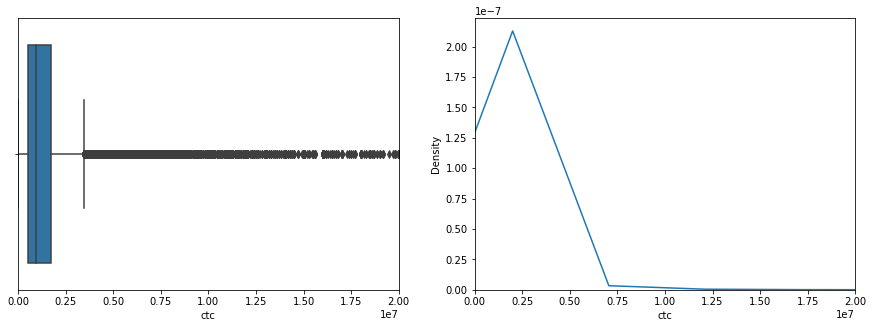

In [235]:
# We have soo many outliers in the CTC column. I will removing those in the future. 
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(df['ctc'])
plt.xlim((0, 0.2*10**8))
plt.subplot(1,2,2)
sns.kdeplot(df['ctc'])
plt.xlim((0, 0.2*10**8))
plt.show()

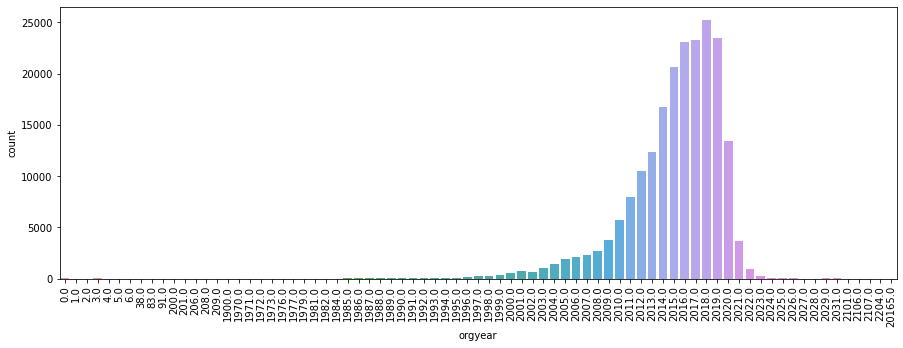

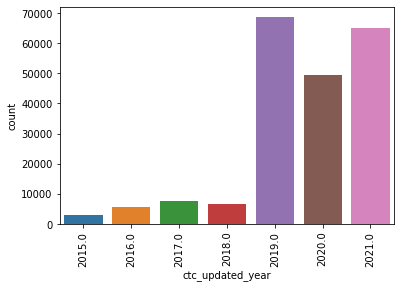

In [236]:
plt.figure(figsize=(15,5))
for features in cat_fea:
    sns.countplot(df[features])
    plt.xticks(rotation='90')
    plt.show()

In [237]:
# Top 10 job positions.
df['job_position'].value_counts()[:10]

Backend Engineer          43554
FullStack Engineer        24717
Other                     18071
Frontend Engineer         10417
Engineering Leadership     6870
QA Engineer                6587
Data Scientist             5368
Android Engineer           5357
SDET                       4967
Devops Engineer            4612
Name: job_position, dtype: int64

#### Feature engineering

In [238]:
df['job_position'].nunique() # There are so many categories in job_position variable. We'll try to reduce the categories.
# We donot have a target variable to encode 

1017

In [239]:
df['job_position'] = df['job_position'].astype('str')

In [240]:
# Let's first convert all the categories to lower letters. 
df['job_position'] = df['job_position'].apply(str.lower)
df['job_position'].nunique()
# We could reduce few categories.

945

In [241]:
# Removing unnessary spaces from the categories. 
def del_spaces(row):
    row=row.split()
    return ' '.join(row)
df['job_position'] = df['job_position'].apply(del_spaces)
df['job_position'].nunique()
# We could reduce some more categories.

909

In [242]:
# We still left with 851 which is a lot. We donot have a target variable to encode all the categories.
df['job_position'].value_counts(normalize=True)[:20]*100
# We can see that there are so many miscellaneous categories which contribute less than 1% out of all the total categories.

nan                       25.534995
backend engineer          21.158844
fullstack engineer        12.622241
other                      8.779507
frontend engineer          5.060653
engineering leadership     3.337495
qa engineer                3.200012
data scientist             2.607813
android engineer           2.602469
sdet                       2.413004
devops engineer            2.240543
support engineer           1.750363
data analyst               1.411756
ios engineer               1.334026
engineering intern         1.308764
product designer           0.638351
backend architect          0.625234
research engineers         0.596571
product manager            0.564022
program manager            0.395447
Name: job_position, dtype: float64

In [243]:
temp = df['job_position'].value_counts(normalize=True)*100
misc_categories = np.array(temp[temp < 1].index)

In [244]:
# Replacing all the categories whose frequency is less than 1 % with a new 'misc' category
df['job_position'].replace(to_replace=misc_categories, value = 'misc', inplace = True)

In [245]:
# We now have only 16 categories which can be encoded with OHE. 
df['job_position'].nunique()

16

In [246]:
# We also have multiple entries of students. 
# We can aggregate them in such a way that we get the student's latest CTC and latest ctc_updated_year(We need this to get YOE).
df['email_hash'].nunique(), df.shape[0]

(153443, 205843)

In [247]:
# Sorting the dataset according to “email_hash”, decreasing “ctc” and decreasing “ctc_updated_year”.
df=df.sort_values(by=['email_hash','ctc','ctc_updated_year'],ascending=[True,False,False])

In [248]:
# Grouping by email_hash and taking the first value in each group.
df = df.groupby(by='email_hash').first().reset_index()

In [249]:
df['email_hash'].nunique(), df.shape[0]

(153443, 153443)

In [250]:
# Adding Years of experience column to our data set. 
df['Years of exp'] = abs(df['ctc_updated_year'] - df['orgyear'])

In [251]:
df.head()

,email_hash,company_hash,orgyear,ctc,job_position,ctc_updated_year,Years of exp
0,00003288036a44374976948c327f246fdbdf0778546904...,bxwqgogen,2012.0,3500000,backend engineer,2019.0,7.0
1,0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...,nqsn axsxnvr,2013.0,250000,backend engineer,2020.0,7.0
2,0000d58fbc18012bf6fa2605a7b0357d126ee69bc41032...,gunhb,2021.0,1300000,nan,2019.0,2.0
3,000120d0c8aa304fcf12ab4b85e21feb80a342cfea03d4...,bxwqgotbx wgqugqvnxgz,2004.0,2000000,fullstack engineer,2021.0,17.0
4,00014d71a389170e668ba96ae8e1f9d991591acc899025...,fvrbvqn rvmo,2009.0,3400000,nan,2018.0,9.0


#### Duplicate value treatment

In [252]:
# No duplicate values were found. 
df.duplicated().value_counts()

False    153443
dtype: int64

#### Missing value treatment

In [253]:
df.isna().sum()/df.shape[0]*100

email_hash          0.000000
company_hash        0.020855
orgyear             0.050833
ctc                 0.000000
job_position        0.000000
ctc_updated_year    0.000000
Years of exp        0.050833
dtype: float64

In [254]:
# Due to dtype conversion of job_position to string, NAN became 'nan'
df[df['job_position'] == 'nan'].shape[0]/df.shape[0]*100

21.566966235018867

In [255]:
# Dropping company_hash and orgyear missing rows as the percentage is very less
df.dropna(subset=['company_hash', 'orgyear'], inplace = True)

In [256]:
# Filling missing values with a new missing category in job_position feature
df['job_position'] = df['job_position'].apply(lambda row : 'missing' if row == 'nan' else row)

In [257]:
df[df['job_position'] == 'nan'].shape[0]/df.shape[0]*100

0.0

In [258]:
# All missing values have been filled
df.isna().sum()/df.shape[0]*100

email_hash          0.0
company_hash        0.0
orgyear             0.0
ctc                 0.0
job_position        0.0
ctc_updated_year    0.0
Years of exp        0.0
dtype: float64

#### Outlier treatment

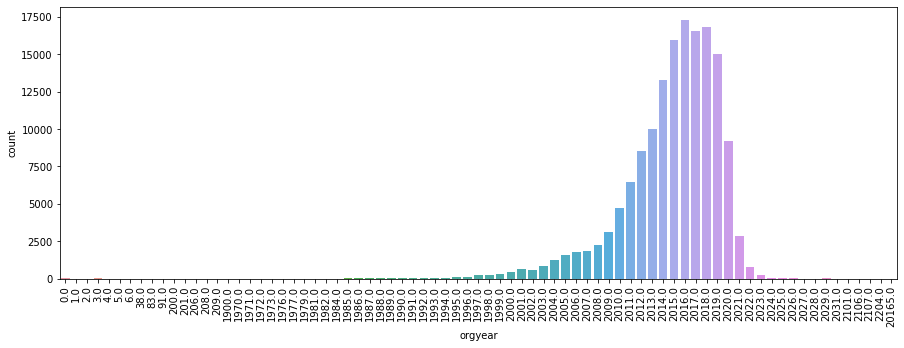

In [259]:
plt.figure(figsize = (15,5))
sns.countplot(df['orgyear'])
plt.xticks(rotation='90')
plt.show()

In [260]:
# lets first drop the rows which has incorrect orgyear and ctc_updated_year. (Years greater than 2022 and years less than 1970
# for orgyear)
df = df[(df['orgyear'] <= 2022) & (df['orgyear'] >= 1970)]
df =  df[(df['ctc_updated_year'] <= 2022)]

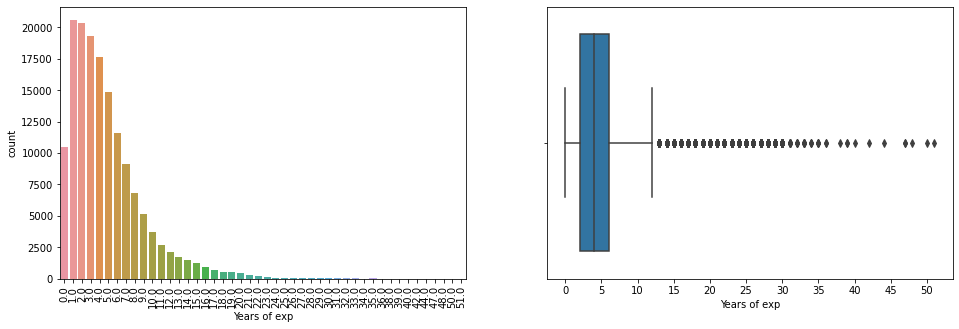

In [261]:
# We can see certain outliers here
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.countplot(df['Years of exp'])
plt.xticks(rotation='90')
plt.subplot(1,2,2)
sns.boxplot(df['Years of exp'])
plt.xticks(np.arange(0,55,5))
plt.show()

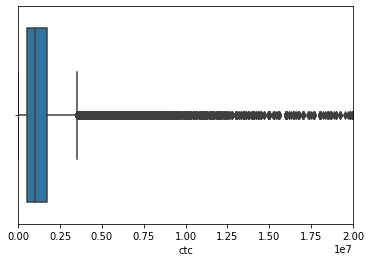

In [262]:
# We can see that there are a lot of outliers
sns.boxplot(df['ctc'])
plt.xlim((0, 0.2*10**8))
plt.show()

In [263]:
# Using IQR method to remove outliers
def IQR(col):
    Q3 = np.percentile(col, 75)
    Q1 = np.percentile(col, 25)
    iqr = Q3-Q1
    upper_lmt = Q3+1.5*iqr
    lower_lmt = Q1-1.5*iqr
    return lower_lmt, upper_lmt

In [264]:
lower_lmt, upper_lmt = IQR(df['ctc'])
df = df[(df['ctc']>=lower_lmt)&(df['ctc']<=upper_lmt)]

In [265]:
lower_lmt, upper_lmt = IQR(df['Years of exp'])
df = df[(df['Years of exp']>=lower_lmt)&(df['Years of exp']<=upper_lmt)]

<AxesSubplot:xlabel='ctc'>

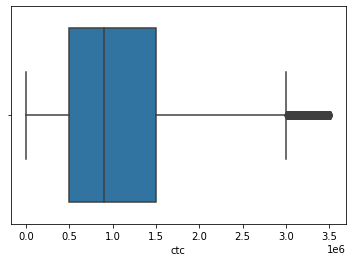

In [266]:
# We have removed most of the outliers from our ctc column
sns.boxplot(df['ctc'])

<AxesSubplot:xlabel='Years of exp'>

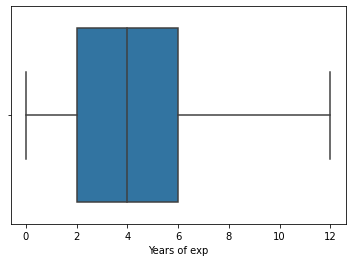

In [267]:
# All outliers have been removed from the YOE column
sns.boxplot(df['Years of exp'])

In [268]:
import copy
#### Storing a temp df for clustering using Kmeans and heirarchical.
df_kmeans = copy.deepcopy(df)

#### Manual Clustering

In [269]:
comp_mean_ctc = df.groupby(['company_hash'])['ctc'].mean().to_frame(name = 'comp_mean_ctc').reset_index()
comp_median_ctc = df.groupby(['company_hash'])['ctc'].median().to_frame(name = 'comp_median_ctc').reset_index()
comp_max_ctc = df.groupby(['company_hash'])['ctc'].max().to_frame(name = 'comp_max_ctc').reset_index()
comp_min_ctc = df.groupby(['company_hash'])['ctc'].min().to_frame(name = 'comp_min_ctc').reset_index()
comp_count_ctc = df.groupby(['company_hash'])['ctc'].count().to_frame(name = 'comp_count_ctc').reset_index()

In [270]:
for dfs in [comp_mean_ctc, comp_median_ctc, comp_max_ctc, comp_min_ctc, comp_count_ctc]:
    df = df.merge(dfs, how = 'left')

In [271]:
comp_jp_mean = df.groupby(['company_hash', 'job_position'])['ctc'].mean().to_frame(name = 'comp_jp_mean').reset_index()
comp_jp_median = df.groupby(['company_hash', 'job_position'])['ctc'].median().to_frame(name = 'comp_jp_median').reset_index()
comp_jp_max = df.groupby(['company_hash', 'job_position'])['ctc'].max().to_frame(name = 'comp_jp_max').reset_index()
comp_jp_min = df.groupby(['company_hash', 'job_position'])['ctc'].min().to_frame(name = 'comp_jp_min').reset_index()
comp_jp_count = df.groupby(['company_hash', 'job_position'])['ctc'].count().to_frame(name = 'comp_jp_count').reset_index()

In [272]:
for dfs in [comp_jp_mean, comp_jp_median, comp_jp_max, comp_jp_min, comp_jp_count]:
    df = df.merge(dfs, how = 'left')

In [273]:
df.head()

,email_hash,company_hash,orgyear,ctc,job_position,ctc_updated_year,Years of exp,comp_mean_ctc,comp_median_ctc,comp_max_ctc,comp_min_ctc,comp_count_ctc,comp_jp_mean,comp_jp_median,comp_jp_max,comp_jp_min,comp_jp_count
0,00003288036a44374976948c327f246fdbdf0778546904...,bxwqgogen,2012.0,3500000,backend engineer,2019.0,7.0,2.021830e+06,2200000.0,3500000.0,5000.0,1112,2.085369e+06,2300000.0,3500000.0,5000.0,397
1,0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...,nqsn axsxnvr,2013.0,250000,backend engineer,2020.0,7.0,2.500000e+05,250000.0,250000.0,250000.0,1,2.500000e+05,250000.0,250000.0,250000.0,1
2,0000d58fbc18012bf6fa2605a7b0357d126ee69bc41032...,gunhb,2021.0,1300000,missing,2019.0,2.0,1.343154e+06,1200000.0,3200000.0,300000.0,136,1.296298e+06,1160000.0,3000000.0,366000.0,47
3,00014d71a389170e668ba96ae8e1f9d991591acc899025...,fvrbvqn rvmo,2009.0,3400000,missing,2018.0,9.0,2.063651e+06,2100000.0,3500000.0,15000.0,435,1.925885e+06,1925000.0,3400000.0,15000.0,78
4,0001b94dbb1e85477b07fb6558ead3456c3735893c81f4...,nvnv wgzohrnvzwj otqcxwto,2018.0,450000,misc,2021.0,3.0,5.754185e+05,459999.0,3400000.0,600.0,5046,5.926401e+05,436500.0,2500000.0,3500.0,132


In [274]:
comp_jp_yoe_mean = df.groupby(['company_hash', 
                                 'job_position', 
                                 'Years of exp'])['ctc'].mean().to_frame(name ='comp_jp_yoe_mean').reset_index()
comp_jp_yoe_median = df.groupby(['company_hash', 
                                   'job_position', 
                                    'Years of exp'])['ctc'].median().to_frame(name = 'comp_jp_yoe_median').reset_index()
comp_jp_yoe_max = df.groupby(['company_hash', 
                                'job_position', 
                                'Years of exp'])['ctc'].max().to_frame(name = 'comp_jp_yoe_max').reset_index()
comp_jp_yoe_min = df.groupby(['company_hash', 
                                'job_position', 
                                'Years of exp'])['ctc'].min().to_frame(name = 'comp_jp_yoe_min').reset_index()
comp_jp_yoe_count = df.groupby(['company_hash', 
                                  'job_position', 
                                  'Years of exp'])['ctc'].count().to_frame(name = 'comp_jp_yoe_count').reset_index()

In [275]:
for dfs in [comp_jp_yoe_mean, comp_jp_yoe_median, comp_jp_yoe_max, comp_jp_yoe_min, comp_jp_yoe_count]:
    df = df.merge(dfs, how = 'left')

In [276]:
df.head()

,email_hash,company_hash,orgyear,ctc,job_position,ctc_updated_year,Years of exp,comp_mean_ctc,comp_median_ctc,comp_max_ctc,...,comp_jp_mean,comp_jp_median,comp_jp_max,comp_jp_min,comp_jp_count,comp_jp_yoe_mean,comp_jp_yoe_median,comp_jp_yoe_max,comp_jp_yoe_min,comp_jp_yoe_count
0,00003288036a44374976948c327f246fdbdf0778546904...,bxwqgogen,2012.0,3500000,backend engineer,2019.0,7.0,2.021830e+06,2200000.0,3500000.0,...,2.085369e+06,2300000.0,3500000.0,5000.0,397,2.048391e+06,2500000.0,3500000.0,53000.0,23
1,0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...,nqsn axsxnvr,2013.0,250000,backend engineer,2020.0,7.0,2.500000e+05,250000.0,250000.0,...,2.500000e+05,250000.0,250000.0,250000.0,1,2.500000e+05,250000.0,250000.0,250000.0,1
2,0000d58fbc18012bf6fa2605a7b0357d126ee69bc41032...,gunhb,2021.0,1300000,missing,2019.0,2.0,1.343154e+06,1200000.0,3200000.0,...,1.296298e+06,1160000.0,3000000.0,366000.0,47,1.261666e+06,1125000.0,2100000.0,919999.0,6
3,00014d71a389170e668ba96ae8e1f9d991591acc899025...,fvrbvqn rvmo,2009.0,3400000,missing,2018.0,9.0,2.063651e+06,2100000.0,3500000.0,...,1.925885e+06,1925000.0,3400000.0,15000.0,78,2.396000e+06,2500000.0,3400000.0,222000.0,7
4,0001b94dbb1e85477b07fb6558ead3456c3735893c81f4...,nvnv wgzohrnvzwj otqcxwto,2018.0,450000,misc,2021.0,3.0,5.754185e+05,459999.0,3400000.0,...,5.926401e+05,436500.0,2500000.0,3500.0,132,6.012222e+05,450000.0,1900000.0,300000.0,18


##### As per the business case, flag features need to be created. 3 flag categories need to be created for each feature.
##### I am using my own set of rules to create tiers as no exact parameters for choosing tiers have been provided. 

- Tier1 - Employee/scaler student's CTC is greater than and equal to both average and median. 
- Tier2 - Employee/scaler student's CTC is greater than and equal to median but less than average or Employee/scaler student's CTC is greater than and equal to average but less than median. 
- Tier3 - Employee/scaler student's CTC is less than both average and median.  

In [277]:
def company_tier(rows):
    if (rows['ctc'] >= rows['comp_mean_ctc']) & (rows['ctc'] >= rows['comp_median_ctc']):
        return 1
    elif ((rows['ctc'] < rows['comp_mean_ctc']) & (rows['ctc'] >= rows['comp_median_ctc'])) or ((rows['ctc'] >= rows['comp_mean_ctc']) & (rows['ctc'] < rows['comp_median_ctc'])):
        return 2
    elif (rows['ctc'] < rows['comp_mean_ctc']) & (rows['ctc'] < rows['comp_median_ctc']):
        return 3

In [278]:
def company_pos_tier(rows):
    if (rows['ctc'] >= rows['comp_jp_mean']) & (rows['ctc'] >= rows['comp_jp_median']):
        return 1
    elif ((rows['ctc'] < rows['comp_jp_mean']) & (rows['ctc'] >= rows['comp_jp_median'])) or ((rows['ctc'] >= rows['comp_jp_mean']) & (rows['ctc'] < rows['comp_jp_median'])):
        return 2
    elif (rows['ctc'] < rows['comp_jp_mean']) & (rows['ctc'] < rows['comp_jp_median']):
        return 3

In [279]:
def company_pos_yoe_tier(rows):
    if (rows['ctc'] >= rows['comp_jp_yoe_mean']) & (rows['ctc'] >= rows['comp_jp_yoe_median']):
        return 1
    elif ((rows['ctc'] < rows['comp_jp_yoe_mean']) & (rows['ctc'] >= rows['comp_jp_yoe_median'])) or ((rows['ctc'] >= rows['comp_jp_yoe_mean']) & (rows['ctc'] < rows['comp_jp_yoe_median'])):
        return 2
    elif (rows['ctc'] < rows['comp_jp_yoe_mean']) & (rows['ctc'] < rows['comp_jp_yoe_median']):
        return 3

In [280]:
# Creating flag features on the company, (company & position) and (company, position & YOE) level
df['company_tier'] = df.apply(company_tier, axis = 1)
df['company_pos_tier'] = df.apply(company_pos_tier, axis = 1)
df['company_pos_yoe_tier'] = df.apply(company_pos_yoe_tier, axis = 1)

In [281]:
df.iloc[:,-3:].head()

,company_tier,company_pos_tier,company_pos_yoe_tier
0,1,1,1
1,1,1,1
2,2,1,1
3,1,1,1
4,3,2,2


#### Answering few questions from the business case.

##### Top 10 employees of data science in Amazon / TCS etc earning more than their peers - Class 1

In [282]:
# We have only one position called data scientist
df[df['job_position'].str.contains('data')]['job_position'].unique()

array(['data analyst', 'data scientist'], dtype=object)

In [283]:
df[(df['job_position'] == 'data scientist') & (df['company_tier'] == 1)].sort_values(by = 'ctc', ascending = False)[['email_hash', 'ctc']].head(10)

,email_hash,ctc
16925,1f5390e2a43f898454234b4ff0a3e35479d1329a3bd566...,3510000
120359,e1d9d01cdcd23cf14e4bd43733138f131b9f412886e826...,3500000
131738,f6e8c41a40ec308c996d498e22729359d2b564cae037a0...,3500000
29022,3633976e6ee8c00448c0d1adac67109e390d5b4cc85113...,3500000
53889,64f740c3820a0785e491a2ad284f4d986f0faa68f330c7...,3500000
31560,3afd334b6b675214c31f2863a1ebd7bdc28440e82e4918...,3500000
97586,b70477650b1616a8d9e9287a1218e107c4349851606551...,3500000
129902,f380b8aab377777dfeb2ca5a8c6de14c49b8bed57bd69b...,3500000
100922,bd5f8865e7147692be50918969d3a620ccb03ab9fcb0cc...,3500000
21731,287146ec4cf52224978f98a6f4d0728005c268d2973f2a...,3500000


##### Bottom 10 employees of data science in Amazon / TCS etc earning less than their peers - Class 3

In [284]:
df[(df['job_position'] == 'data scientist') & (df['company_tier'] == 3)].sort_values(by = 'ctc', ascending = False)[['email_hash', 'ctc']].tail(10)

,email_hash,ctc
69430,8274b3188470cd1c4914e7face490111e27f239457e62d...,10000
134113,fb64af615420e06d46a1965f59068b34460fb3cbe70541...,10000
115677,d920a8aa9b63eb317a34bc6cfc4010ec1bb1146f149cb3...,9000
29160,3675f79c7e05de96ccf189c818b84b487cb1aa3f6b80e8...,8800
41888,4ed3d04bca6467a839f7a4f878bc15737c3c4afa9cb3a5...,8000
110476,cf663c71fc96db1ea5658342e2d73050b40ca479d324de...,8000
26444,3175d03fd4618eb293d6f5a1d13d42a0c79f68e9acaaa3...,7500
101055,bd9c04a574090e05b366a81cdb2f3f565d0c60fa8b1647...,6000
68143,8001bc017fbe95541d23f5780c3edb988b7d9b2225e39e...,4000
56060,690f6fdab1ab7514a6a9325ebd6cfe910dbf12d46b6fde...,4000


##### Bottom 10 employees (earning less than most of the employees in the company)- Tier 3

In [285]:
df[(df['company_tier'] == 3)].sort_values(by = 'ctc', ascending = False)[['email_hash', 'ctc']].tail(10)

,email_hash,ctc
89222,a7894c6d848de3021cfd16b35178cf8f48b10d77aa46dc...,1000
75092,8d1e069a03fc437876b406b8c93bc7e07577f9836222bd...,1000
40969,4d18008fc2cb66e4b90f3798ccbbc4792dfd4bad5a7a87...,1000
42377,4fb9d1474a93c4011ab638c130974b5f845b5f5dc06a5f...,1000
115756,d9476096e4e5d6f0b0f6079b0543145f62b43c82478bbc...,1000
68519,80ba0259f9f59034c4927cf3bd38dc9ce2eb60ff18135b...,600
98439,b8a0bb340583936b5a7923947e9aec21add5ebc50cd60b...,15
19205,23ad96d6b6f1ecf554a52f6e9b61677c7d73d8a409a143...,14
129428,f2b58aeed3c074652de2cfd3c0717a5d21d6fbcf342a78...,6
28421,3505b02549ebe2c95840ac6f0a35561a3b4cbe4b79cdb1...,2


##### Top 10 employees in Amazon- X department - having 5/6/7 years of experience earning more than their peers - Tier X

In [286]:
df[(df['job_position'] == 'X') & 
   ((df['Years of exp'] == 5) | 
   (df['Years of exp'] == 6) |
  (df['Years of exp'] == 7))].sort_values(by = 'ctc', ascending = False)[['email_hash', 'ctc']].head(10)

,email_hash,ctc


##### Top 10 companies (based on their CTC)

In [287]:
df[['company_hash', 'comp_mean_ctc']].sort_values(by='comp_mean_ctc', ascending=False).head(10)

,company_hash,comp_mean_ctc
124298,ahmvx trtwnqxwxnj vza fvntq vhnygqxnj,3510000.0
16925,bxnohmxoyx ehog nqhwp vza mho wgqugqvnxgz,3510000.0
61273,urvjkxg,3500000.0
85461,zvcxoxnt,3500000.0
15122,tvxzegmxk xzw,3500000.0
45676,zvnxgzvr vrhbxzxhb wgbuvzj rxbxnta zvrwg,3500000.0
85845,xaxvu qtotvqwy xzonxnhnt,3500000.0
18709,mvzqxohr,3500000.0
108403,yvzsvq xzaxv,3500000.0
10886,ozvuatvr xzaxv,3500000.0


##### Top 2 positions in every company (based on their CTC)

In [288]:
df.sort_values(['company_hash',
                'job_position',
        'comp_jp_mean'],ascending=False).groupby(['company_hash', 'job_position']).head(3)[['company_hash', 'job_position']]

,company_hash,job_position
113032,zzgato,missing
107849,zzb ztdnstz vacxogqj ucn rna,fullstack engineer
66638,zz,other
114309,zz,missing
39290,zyvzwt wgzohrnxzs tzsxzttqo,frontend engineer
...,...,...
37833,05mz exzytvrny uqxcvnt rxbxnta,missing
120376,01 ojztqsj,frontend engineer
68973,01 ojztqsj,android engineer
95903,0000,other


#### Categorical Encoding

In [289]:
df_kmeans.head()

,email_hash,company_hash,orgyear,ctc,job_position,ctc_updated_year,Years of exp
0,00003288036a44374976948c327f246fdbdf0778546904...,bxwqgogen,2012.0,3500000,backend engineer,2019.0,7.0
1,0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...,nqsn axsxnvr,2013.0,250000,backend engineer,2020.0,7.0
2,0000d58fbc18012bf6fa2605a7b0357d126ee69bc41032...,gunhb,2021.0,1300000,missing,2019.0,2.0
4,00014d71a389170e668ba96ae8e1f9d991591acc899025...,fvrbvqn rvmo,2009.0,3400000,missing,2018.0,9.0
5,0001b94dbb1e85477b07fb6558ead3456c3735893c81f4...,nvnv wgzohrnvzwj otqcxwto,2018.0,450000,misc,2021.0,3.0


In [290]:
from sklearn.preprocessing import OneHotEncoder

In [291]:
ohe = OneHotEncoder()
ohe_fea = ohe.fit_transform(df_kmeans['job_position'].values.reshape(-1,1)).toarray()
ohe.categories_, ohe_fea

([array(['android engineer', 'backend engineer', 'data analyst',
         'data scientist', 'devops engineer', 'engineering intern',
         'engineering leadership', 'frontend engineer',
         'fullstack engineer', 'ios engineer', 'misc', 'missing', 'other',
         'qa engineer', 'sdet', 'support engineer'], dtype=object)],
 array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [292]:
for i in range(len(ohe.categories_)):
    df_kmeans[ohe.categories_[i]] = ohe_fea[i]

In [293]:
# We do not need the job_position now after OHE.
df_kmeans.drop('job_position', axis = 1, inplace = True)

In [294]:
# We also do not need email_hash and company_hash as the hashed columns dont make sense.
df_kmeans.drop(['company_hash', 'email_hash'], axis = 1, inplace = True)

In [295]:
df_kmeans.head()

,orgyear,ctc,ctc_updated_year,Years of exp,android engineer,backend engineer,data analyst,data scientist,devops engineer,engineering intern,engineering leadership,frontend engineer,fullstack engineer,ios engineer,misc,missing,other,qa engineer,sdet,support engineer
0,2012.0,3500000,2019.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013.0,250000,2020.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021.0,1300000,2019.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2009.0,3400000,2018.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2018.0,450000,2021.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


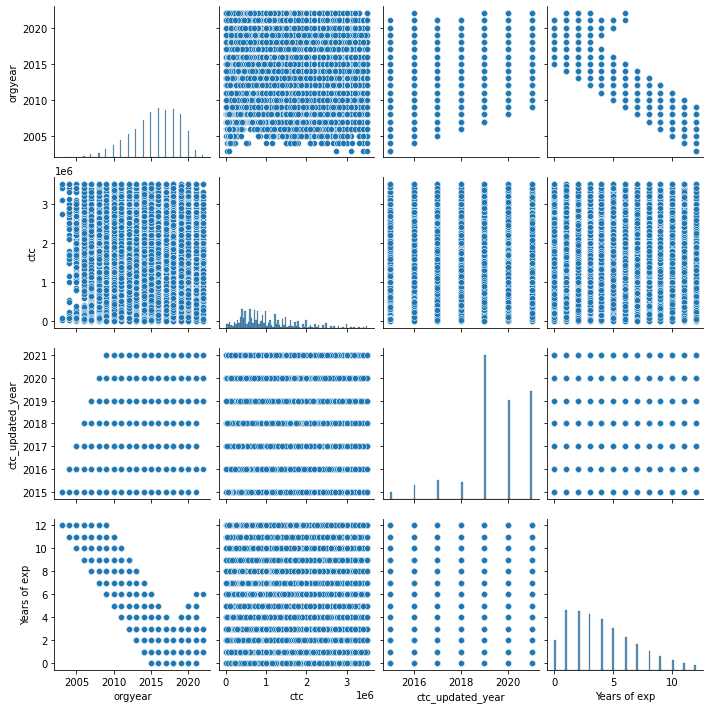

In [296]:
### No visible clusters can be seen as of now. Choosing k=3 as an arbitrary value. We can use YOE, orgyear and CTC to check
### clusters using visualisation.
sns.pairplot(df_kmeans.iloc[:,:4])

<AxesSubplot:>

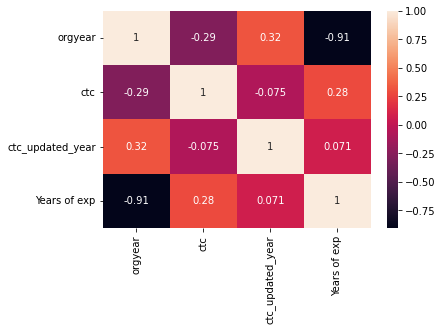

In [297]:
# Heapmap
sns.heatmap(df_kmeans.iloc[:,:4].corr(), annot=True)
# Only high negative correlation can be seen between YOE and orgyear

#### Scaling the features

In [298]:
from sklearn.preprocessing import StandardScaler

In [299]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df_kmeans), columns=df_kmeans.columns)

In [300]:
scaled_df.head(3)

,orgyear,ctc,ctc_updated_year,Years of exp,android engineer,backend engineer,data analyst,data scientist,devops engineer,engineering intern,engineering leadership,frontend engineer,fullstack engineer,ios engineer,misc,missing,other,qa engineer,sdet,support engineer
0,-1.122106,3.209264,-0.336661,1.039013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.808066,-1.110984,0.388966,1.039013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.704254,0.284788,-0.336661,-0.699057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Kmeans Clustering

In [301]:
from sklearn.cluster import KMeans

In [302]:
#### Fitting the data set and getting the labels
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit_predict(scaled_df)
scaled_df['kmeans_labels'] = kmeans.labels_

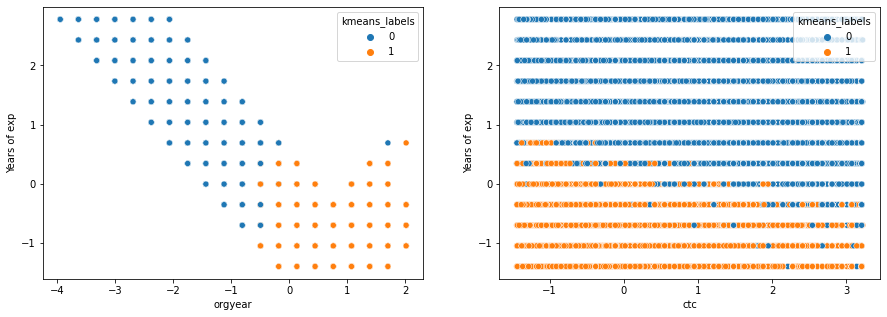

In [303]:
# K = 2 is doing a fine job but lets use elbow method to decide the value of k.
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.scatterplot(x = scaled_df['orgyear'], y = scaled_df['Years of exp'], hue = scaled_df['kmeans_labels'])
plt.subplot(1,2,2)
sns.scatterplot(x = scaled_df['ctc'], y = scaled_df['Years of exp'], hue = scaled_df['kmeans_labels'])
plt.show()

In [304]:
from sklearn.metrics import davies_bouldin_score

In [305]:
# Calculating WCSS and silhouette score for different values of K.
wcss = []
dbs = []
for k in range(2, 11):
    KM = KMeans(n_clusters=k, random_state=42)
    KM.fit(scaled_df.iloc[:,:-1])
    wcss.append(KM.inertia_)
    dbs.append(davies_bouldin_score(scaled_df.iloc[:,:-1], KM.labels_))

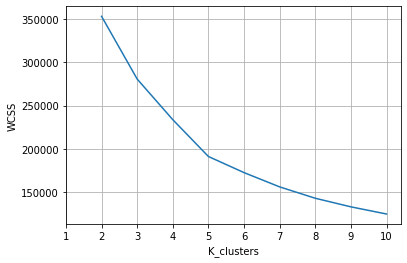

In [306]:
# Using Elbow method to find the best value of k with WCSS score. 
sns.lineplot(x = range(2, 11), y = wcss)
plt.xlabel('K_clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

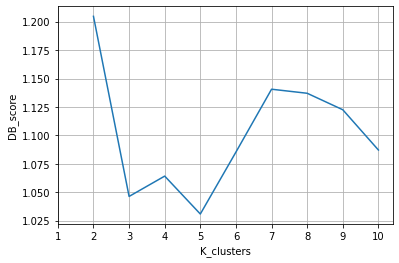

In [307]:
# Using Elbow method to find the best value of k with DB index. 
sns.lineplot(x = range(2, 11), y = dbs)
plt.xlabel('K_clusters')
plt.ylabel('DB_score')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

##### Both the plots are showing 5 as the best value of K. But, we can also see that 3 has DB_score almost close to 5. 

In [308]:
#### Retraining the model with n_clusters=5, 4, 3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit_predict(scaled_df)
scaled_df['kmeans_labels'] = kmeans.labels_

<Figure size 1440x1440 with 0 Axes>

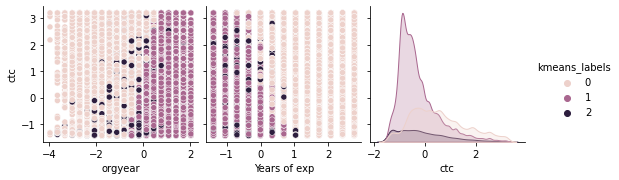

In [309]:
# We are not able to observe good clusters in this 2d plot. 
plt.figure(figsize=(20,20))
sns.pairplot(scaled_df[['orgyear', 'Years of exp', 'ctc', 'kmeans_labels']], hue='kmeans_labels', y_vars='ctc')
plt.show()

<Figure size 1440x1440 with 0 Axes>

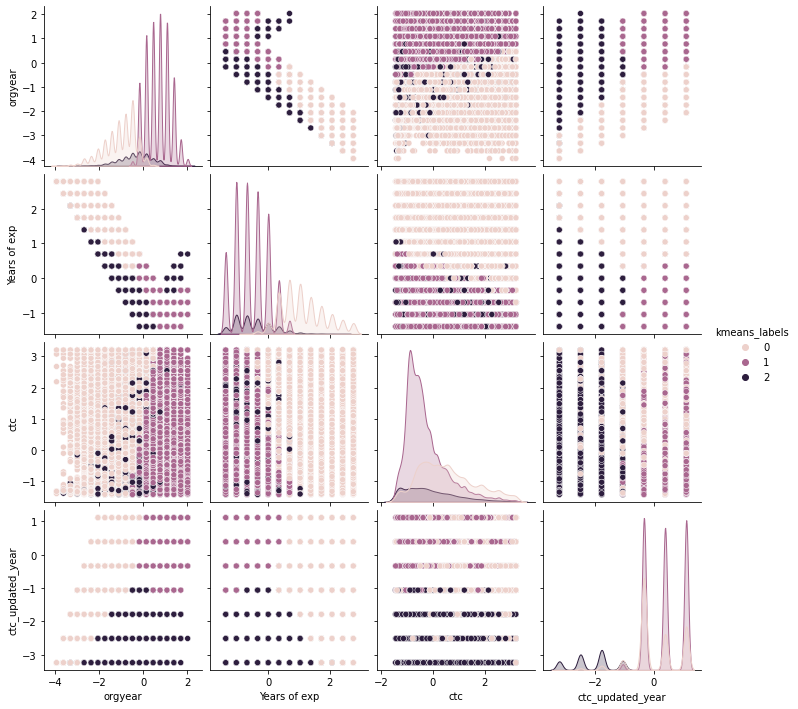

In [310]:
plt.figure(figsize=(20,20))
sns.pairplot(scaled_df[['orgyear', 'Years of exp', 'ctc', 'ctc_updated_year', 'kmeans_labels']], hue = 'kmeans_labels')

In [311]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)

In [312]:
x = pd.DataFrame(pca.fit_transform(scaled_df.iloc[:,:-1]))

In [313]:
x['kmeans_labels'] = scaled_df['kmeans_labels']

<AxesSubplot:xlabel='0', ylabel='1'>

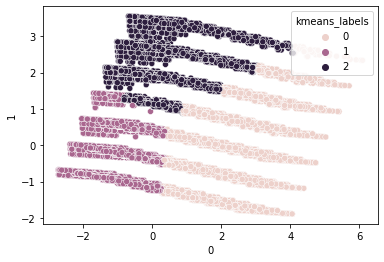

In [314]:
sns.scatterplot(x = x[0], y = x[1], hue = x['kmeans_labels'])

##### After rigourously training and plotting different clusters, I found 3 clusters to be the optimum k.

##### Interpreting Results of KMeans

- Actual clusters were clearly observed on scatter plot between ctc and years of experience. We can also observe patterns using other columns but the explaining the cluster here make sense as per my domain knowledge.
- The 3 clusters are 3 different groups of people with different ctcs and different years of experience. 
- Cluster 1 - Students with low ctc and low YOE.
- Cluster 2 - Students with low ctc and high YOE and Students with high ctc and low YOE.
- Cluster 3 - Students with higher YOE and all CTC.
- We can also see that these clusters group joining_year for different ctc perfectly.

#### Heirarchical clustering

In [315]:
import scipy.cluster.hierarchy as sch

In [316]:
# Taking a sample of just 50 points chosen at random to plot a dendogram
sample = scaled_df.drop('kmeans_labels', axis = 1).sample(100, random_state=42)

In [317]:
# Using ward linkage technique on sample data to get clusters
Z = sch.linkage(sample, method='ward')

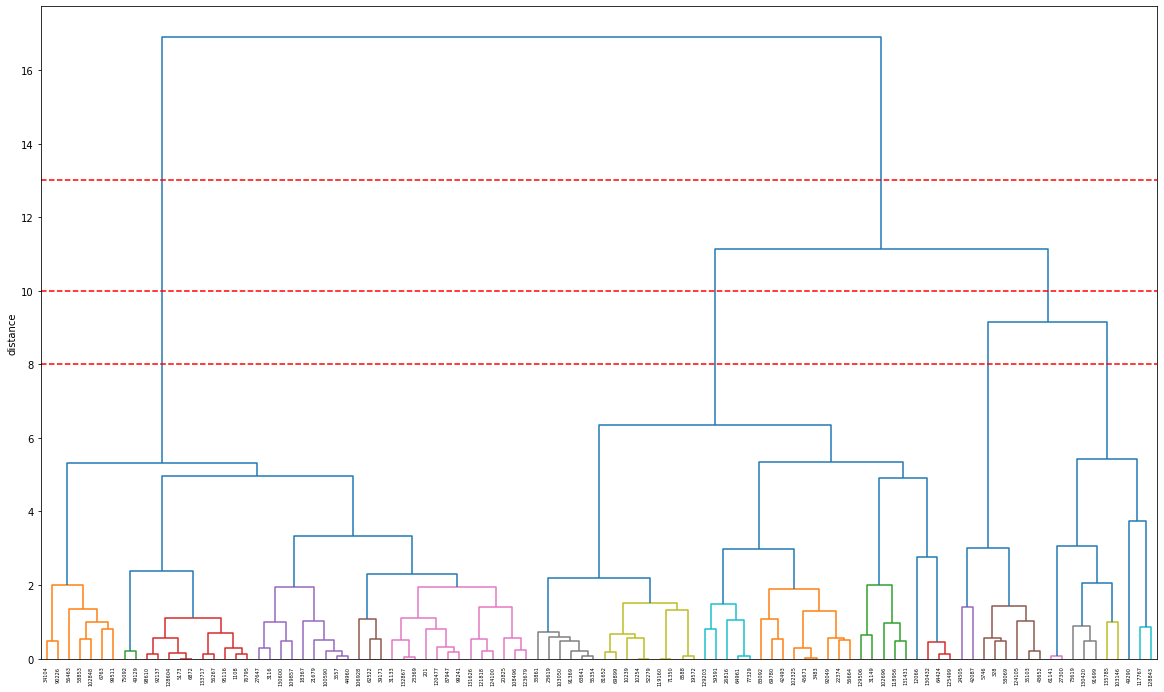

In [318]:
# We can take clusters as either 2,3 or 4 from the plot given below. 
fig, ax = plt.subplots(figsize=(20, 12))
sch.dendrogram(Z, labels=sample.index, ax=ax, color_threshold=2)
plt.xticks(rotation=90)
plt.axhline(y = 8, color = 'r', linestyle = '--')
plt.axhline(y = 10, color = 'r', linestyle = '--')
plt.axhline(y = 13, color = 'r', linestyle = '--')
ax.set_ylabel('distance')
plt.show()

In [319]:
from sklearn.cluster import AgglomerativeClustering

In [320]:
# Using AgglomerativeClustering from scikit learn to fit the scaled_data on a random sample of 30000 points
heirarchy = AgglomerativeClustering(n_clusters=2, affinity = 'euclidean', linkage = 'ward')
samples = scaled_df.drop('kmeans_labels', axis = 1).sample(30000, random_state = 42)
heirarchy.fit(samples)
samples['heirarchy_labels'] = heirarchy.labels_

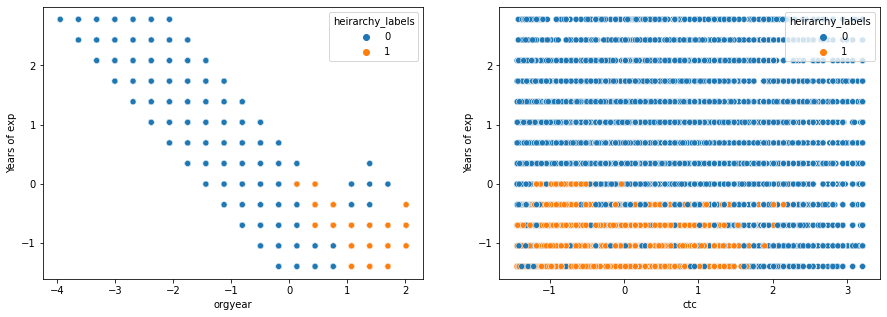

In [321]:
# 2 clusters seem to be clearly distinguishing the clusters.
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.scatterplot(x = samples['orgyear'], y = samples['Years of exp'], hue = samples['heirarchy_labels'])
plt.subplot(1,2,2)
sns.scatterplot(x = samples['ctc'], y = samples['Years of exp'], hue = samples['heirarchy_labels'])
plt.show()

<Figure size 1440x1440 with 0 Axes>

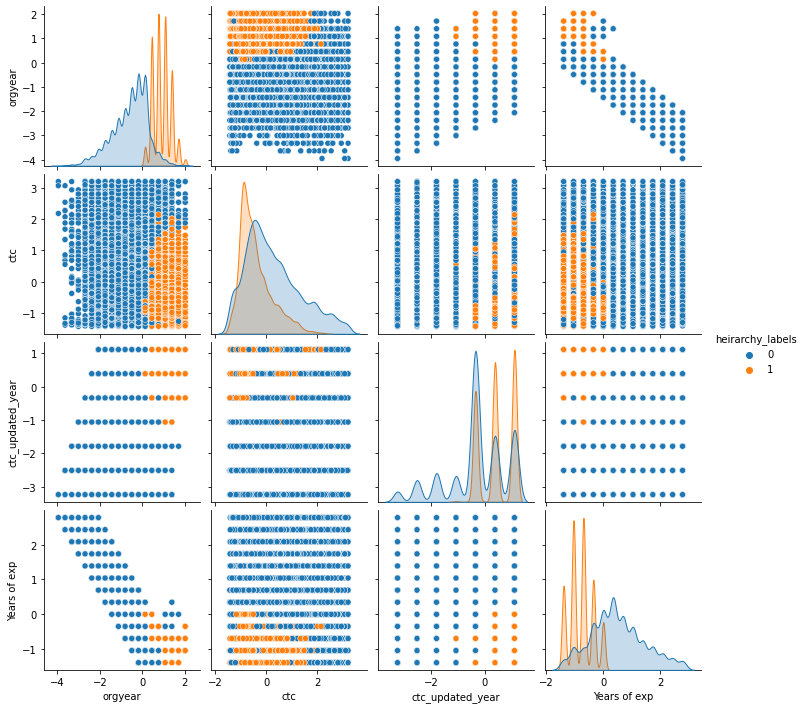

In [322]:
plt.figure(figsize=(20,20))
sns.pairplot(samples[['orgyear', 'ctc', 'ctc_updated_year', 'Years of exp', 'heirarchy_labels']], hue = 'heirarchy_labels')

##### After rigourously training and plotting different clusters, I found 2 clusters to be the optimum.

##### Interpreting Results of Hierarchical

- Actual clusters were again clearly observed on scatter plot between ctc and years of experience. We can also observe patterns using other columns but the explaining the cluster here make sense as per my domain knowledge.
- The 2 clusters are 2 different groups of people with different ctcs and different years of experience. 
- Cluster 1 - Students with low ctc and low YOE.
- Cluster 2 - Students with high YOE for all CTC
- We can also see that these clusters group joining_year for different ctc perfectly.